In [3]:
%matplotlib inline
from tqdm import tqdm
import pandas as pd
import numpy as np
import pymc3 as pm
from theano import shared
import theano.tensor as tt
import theano
from pymc3.distributions.transforms import t_stick_breaking

In [4]:
import re
def plot_traces(trcs, varnames=None):
    '''Plot traces with overlaid means and values'''

    nrows = len(trcs.varnames)
    if varnames is not None:
        nrows = len(varnames)

    ax = pm.traceplot(trcs, varnames=varnames, figsize=(12,nrows*1.4),
                      lines={k: v['mean'] for k, v in
                             pm.summary(trcs,varnames=varnames).iterrows()})

    for i, mn in enumerate(pm.summary(trcs, varnames=varnames)['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data',
                         xytext=(5,10), textcoords='offset points', rotation=90,
                         va='bottom', fontsize='large', color='#AA0022')
def strip_derived_rvs(rvs):
    '''Remove PyMC3-generated RVs from a list'''

    ret_rvs = []
    for rv in rvs:
        if not (re.search('_log',rv.name) or re.search('_interval',rv.name)):
            ret_rvs.append(rv)
    return ret_rvs

In [14]:
import pickle
with open('data/fch-10000-20-0.20.pkl', 'rb') as f:
  GCH, TH = pickle.load(f)
S = 20
npdata = np.array(GCH, dtype = int)
V = len(GCH)
V, type(V)

(5212, int)

In [15]:
def get_vmask():
    v_mask = np.zeros([S,S,S])
    for s in np.arange(S):
        for q in np.arange(s,S):
            c1 = np.zeros(s)
            c2 = np.ones(q-s)
            c3 = np.zeros(S-q)
            v_mask[s,q]= np.concatenate((c1, c2, c3))
    return tt.constant(v_mask)

In [16]:
def get_imask():
    s_mask = np.zeros([V,S])
    q_mask = np.zeros([V,S])
    for w in np.arange(V):
        f, l = npdata[w, 0] , npdata[w, 1]
        s_mask[w] = np.concatenate((np.ones(f+1), np.zeros(S - f -1)))
        q_mask[w] = np.concatenate((np.zeros(l), np.ones(S-l)))
    i_mask = np.einsum("is,iq->isq", s_mask, q_mask)
    return tt.constant(i_mask)

In [17]:
def get_Risq(p):
    tmp_u = npdata[:, 2]
    expanded_u = tmp_u[:, np.newaxis, np.newaxis] *  np.ones((V, S, S)) # V x S x S
    d = np.broadcast_to(np.triu(np.ones([S,S]), 0).cumsum(axis =1), (V, S, S)) # V x S x S
    n = tt.constant(d)
    n_u = np.triu(d - expanded_u, 0)
    n_u = tt.constant(np.clip(n_u,a_min=0,a_max=d)) # V x S x S
    expanded_u = tt.constant(expanded_u)    
    # The beta binomial
    R_isq =   tt.gammaln(n+1)
    R_isq -=  tt.gammaln(expanded_u+1)
    R_isq -=  tt.gammaln(n_u+1)
    R_isq += (n * tt.log(p))+ (n_u * tt.log(1-p))
    # The above is the computation of the log, so we take the exponent
    return tt.exp(R_isq)

In [18]:
def get_Risq0(p):
    # n = q - s + 1
    n = tt.constant(np.triu(np.ones([S,S]), 0).cumsum(axis =1))
    R0_sq = n * tt.log(1-p)
    return tt.exp(R0_sq)

In [19]:
def logp_capture(arr, phi, p, U):
    def ll_capture_f(mycaptures):
        
        # Masks: try to compute these once.
        phi_mask = get_vmask()  # S x S x S . all possible arrivals and departures for the "SURVIVAL"
        i_mask   = get_imask()  # KxK   . matrix with real possible arrival and departures
        R_isq = get_Risq(p) #
        R0_sq = get_Risq0(p) #
        
        # Likelihood of Capture Li
        phi_v = tt.pow(1-phi, phi_mask)
        phi_v = tt.prod(phi_v, axis=2)
        LD = arr[:, np.newaxis] * phi_v * phi
        LD_isq = tt.mul(LD, i_mask)
        Li = tt.batched_tensordot(LD_isq, R_isq, axes = 2)
        
        # Likelihood of No-Capture L0
        v0_mask = 1 - phi_mask[0] # tihs is reuse
        LD0 = tt.mul(LD, v0_mask)
        L0 = tt.sum(LD0 * R0_sq)
        
        # Multinomial
        obj1 = tt.gammaln(tt.constant(V)+U+1.0) - tt.gammaln(U+1.0) - tt.gammaln(tt.constant(V)+ 1.0) #
        obj2 = tt.sum(tt.log(Li))
        obj3 = U * tt.log(L0)
        
        objective = obj1 + obj2 + obj3 
        
        return objective
    
    return ll_capture_f

In [20]:
#birth_init, dep = (np.array([0.4       , 0.06666667, 0.06666667, 0.06666667, 0.06666667,
#          0.06666667, 0.06666667, 0.06666667, 0.06666667, 0.06666667]),
# np.array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 1. ]))
#for UU in range(87600, 88400, 10):
#    print("Total Unseen:", UU, "/ Likelihood:", logp_capture(birth_init, dep, .25,  5., UU)(npdata).eval().round(4))
#print("Total Unseen:", UU, "/ Likelihood:", logp_capture(birth_init, dep, .25,  5., 100000-V)(npdata).eval().round(4))

In [36]:
# custom log-liklihood
# model
with pm.Model() as model2:
    # parameters
    U = pm.Uniform('Unseen', lower=V, upper=3*V)
    p = pm.Uniform('propensity', 0., 1.)
    phi    = pm.Uniform('departure', 0.1, 1., shape=S)
    arr    = pm.Dirichlet('arrival', a=np.array([1./S]*S), shape=S)
    
    # Model Log-likelihood
    ob = pm.DensityDist('x', logp_capture(arr, phi, p, U), observed=npdata)

In [37]:
with model2:
  #posterior = pm.sample(3, tune=0, chains=1, progressbar=False)
  #step = pm.NUTS()
  #posterior = pm.sample(100000, step=step, njobs = 4)
  posterior = pm.sample(100)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [arrival, departure, propensity, Unseen]
Sampling 2 chains: 100%|██████████| 1200/1200 [1:21:50<00:00,  1.26draws/s]     


In [ ]:
for RV in model.basic_RVs:
    print(RV.name, RV.logp(model.test_point))

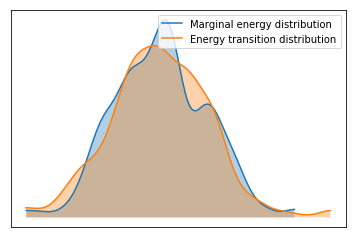

In [38]:
pm.energyplot(posterior);

IndexError: index 4 is out of bounds for axis 0 with size 4

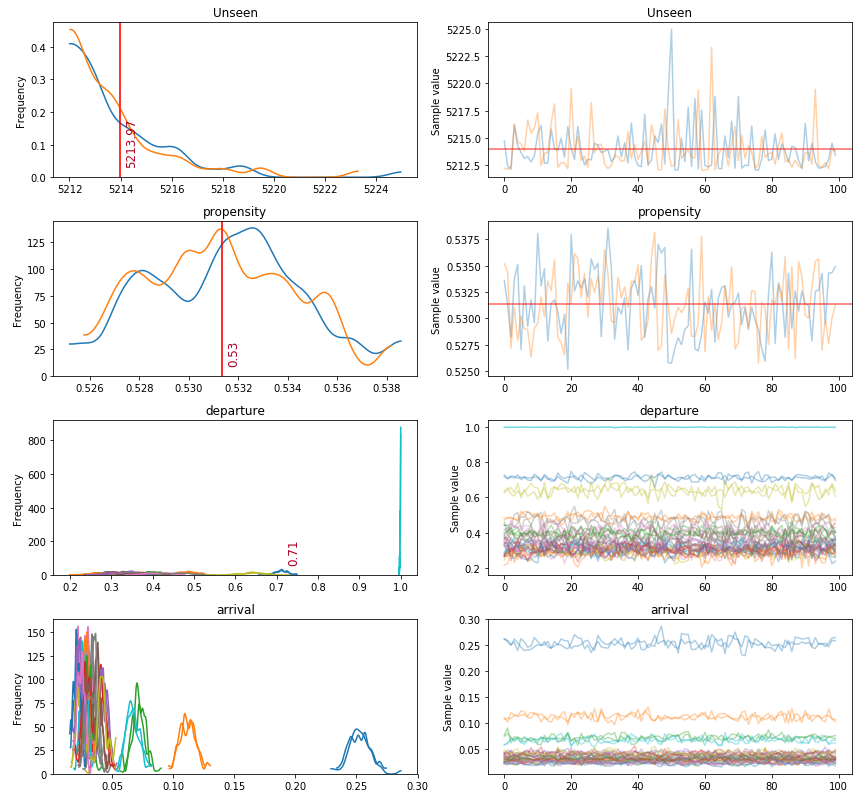

In [39]:
plot_traces(posterior)

In [40]:
pm.summary(posterior).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Unseen,5213.97,2.01,0.13,5212.01,5218.21,290.36,1.00
propensity,0.53,0.00,0.00,0.53,0.54,180.55,1.00
departure__0,0.71,0.01,0.00,0.69,0.74,210.56,1.00
departure__1,0.49,0.02,0.00,0.45,0.52,122.33,1.03
departure__2,0.40,0.02,0.00,0.35,0.44,164.69,1.03
departure__3,0.31,0.02,0.00,0.26,0.35,211.13,1.00
departure__4,0.34,0.02,0.00,0.29,0.38,207.18,1.00
departure__5,0.32,0.02,0.00,0.27,0.36,193.61,1.00
departure__6,0.30,0.03,0.00,0.24,0.35,173.76,1.00
departure__7,0.35,0.02,0.00,0.30,0.39,174.22,1.00


In [ ]:
V

In [ ]:
model['Unseen'].logp(model.test_point)

In [ ]:
model['a'].logp(model.test_point)